In [2]:
import pathlib
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [45]:
folder = pathlib.Path('./../dataset/seq50unrect2')
calib_folder = pathlib.Path('./../dataset/calibration')
calib1 = str(calib_folder / '00000.jpg')
calib2 = str(calib_folder / '00942.jpg')

images = list(folder.iterdir())
images = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in images]

In [18]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*8,3), np.float32)
objp[:,:2] = np.mgrid[0:5,0:8].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in [calib1, calib2]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (5,8),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (5,8), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(0)

cv2.destroyAllWindows()

True
True


In [19]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

In [76]:
dist

array([[-3.08757251e-01,  1.53776395e-01,  8.04696858e-04,
        -7.47559209e-05, -4.97802247e-02]])

In [72]:
mtx

array([[745.29454258,   0.        , 626.382971  ],
       [  0.        , 745.86507438, 505.33888801],
       [  0.        ,   0.        ,   1.        ]])

In [75]:
camera_matrix

array([[277.523987,   0.      , 312.474304],
       [  0.      , 291.680328, 240.035583],
       [  0.      ,   0.      ,   1.      ]])

In [24]:
camera_matrix = mtx

In [73]:
import config

In [74]:
fx = config.CAMERA_CALIBRATION[0]
fy = config.CAMERA_CALIBRATION[1]
cx = config.CAMERA_CALIBRATION[2]
cy = config.CAMERA_CALIBRATION[3]

camera_matrix = np.array(
    [[fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]]
)

In [25]:
good_ratio = 0.5

In [46]:
img1 = images[0] # queryImage
img2 = images[1] # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []

for m, n in matches:
    if m.distance < good_ratio * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

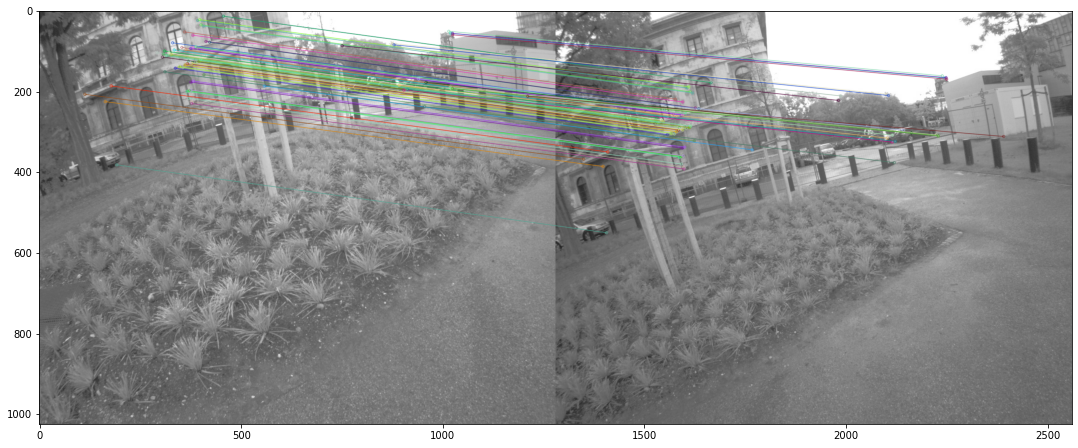

In [47]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img3)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [48]:
pts_im1 = [kp1[m[0].queryIdx].pt for m in good]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m[0].trainIdx].pt for m in good]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

In [49]:
retval, mask = cv2.findHomography(pts_im1.T, pts_im2.T, cv2.RANSAC, 50.0)

In [50]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

In [12]:
# img1c = cv2.imread()
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
# good = np.reshape(np.array(good), -1)
# img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
# plt.imshow(img3, 'gray'), plt.show()

In [13]:
# essential matrix

In [51]:
# https://stackoverflow.com/questions/31431047/3d-reconstruction-from-two-calibrated-cameras-where-is-the-error-in-this-pipel
# normalised coordinates ? also what to do with normals in decomposeHomographyMat?

def choose_points(src_pts, dst_pts, choices):
    if choices > src_pts.shape[0]:
        raise Exception(f'Invalid number of choices, max: {src_pts.shape[0]}')
    
    corrs = []
    choices = np.random.choice(src_pts.shape[0], size=choices, replace=False)
    for i in choices:
        corrs.append((src_pts[i], dst_pts[i]))
        # normalize points ?
    return np.array(corrs)

    
def find_projection_matrix(camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=10):
    # creates projection matrix for the reference (first) camera
    rt_mat_orig = np.hstack((np.identity(3), np.zeros(3)[np.newaxis].T))
    projection_mat_orig = np.dot(camera_matrix, rt_mat_orig)
    
    solutions = []
    points = choose_points(src_pts, dst_pts, choices)
    combinations = [(rot1, trans), (rot1, -trans), (rot2, trans), (rot2, -trans)]
    for rot, t in combinations:
        # creates projection matrix for the second camera
        rt_mat_2nd = np.hstack((rot, t))
        projection_mat_2nd = np.dot(camera_matrix, rt_mat_2nd)
        
        pts_3d = cv2.triangulatePoints(
            projection_mat_orig, projection_mat_2nd, points[:, 0], points[:, 1]
        )
        uhomo_pts_3d = np.array([pts_3d[0]/pts_3d[3], pts_3d[1]/pts_3d[3], pts_3d[2]/pts_3d[3]])
        if np.any(uhomo_pts_3d[2, :] < 0):
            continue  # invalid solution, point is behind the camera

        solutions.append({
            'pro_mat_1st': projection_mat_orig,
            'pro_mat_2nd': projection_mat_2nd,
            't_vec': t,
            'rt_mat': rt_mat_2nd
        })
    if len(solutions) > 1:
        choices += 1
        if choices > src_pts.shape[0]:
            raise Exception('Couldnt find unique solution to point triangulation')
        return find_projection_matrix(
            camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=choices
        )
    if not solutions:
        raise Exception('Couldnt find any solution to point triangulation')
    return solutions[0]
    
    

In [52]:
# Essential matrix
E, mask = cv2.findEssentialMat(src_pts, dst_pts, camera_matrix, cv2.RANSAC, 0.5)

In [53]:
rot1, rot2, trans = cv2.decomposeEssentialMat(E)
solution = find_projection_matrix(camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=19)
pts_3d = cv2.triangulatePoints(
    solution['pro_mat_1st'], solution['pro_mat_2nd'], src_pts, dst_pts
)

Exception: Couldnt find unique solution to point triangulation

In [15]:
unhomo_pts_3d = (pts_3d.T / np.expand_dims(pts_3d.T[:, 3], axis=1))[:,0:3]

In [16]:
camera_1st = np.array([0, 0, 0])
camera_2nd = (camera_1st + solution['t_vec'].T)[0]

In [17]:
# Fundamental matrix
pinv_camera_t = np.linalg.pinv(camera_matrix.T)
pinv_camera = np.linalg.pinv(camera_matrix)
x = np.dot(pinv_camera_t, E)
F = np.dot(x, pinv_camera)  # C^-T * E * C^-1

In [18]:
F = F / F[-1, -1]

In [19]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1[0]), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2[0]), 5, color, -1)
    return img1,img2

<ipython-input-19-63a90952f9bf>:12: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img1 = cv2.circle(img1, tuple(pt1[0]), 5, color, -1)
<ipython-input-19-63a90952f9bf>:13: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img2 = cv2.circle(img2, tuple(pt2[0]), 5, color, -1)


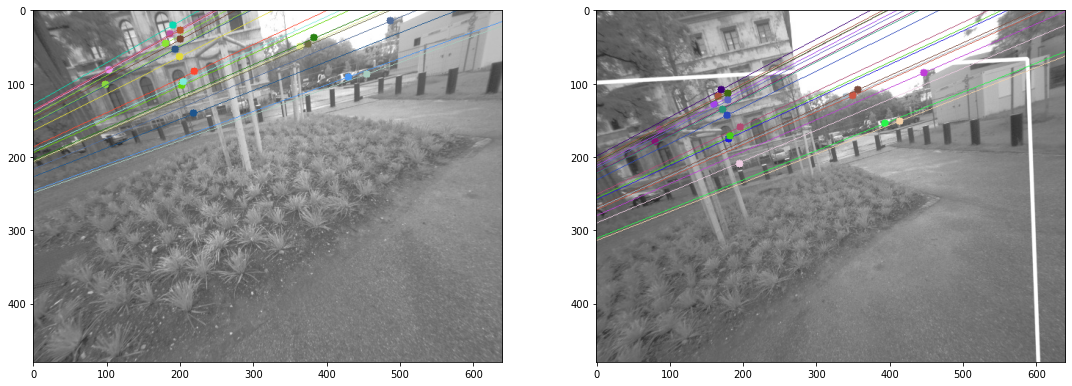

In [20]:
lines1 = cv2.computeCorrespondEpilines(dst_pts, 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1, img2, lines1, src_pts, dst_pts)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(src_pts, 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img2, img1, lines2, dst_pts, src_pts)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img5)
ax[1].imshow(img3)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [23]:
# show where 3d points are and where camera is
# try other images

In [66]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('./../dataset/seq50rect2/00000.jpg',0)  #queryimage # left image
img2 = cv2.imread('./../dataset/seq50rect2/00185.jpg',0) #trainimage # right image
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [67]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [68]:
E, mask = cv2.findEssentialMat(pts1, pts2, camera_matrix, cv2.RANSAC, 0.5)
pinv_camera_t = np.linalg.inv(camera_matrix.T)
pinv_camera = np.linalg.inv(camera_matrix)
x = np.dot(pinv_camera_t, E)
F = np.dot(x, pinv_camera)
F = F / F[-1, -1]
F2, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

print(F - F2)

[[-1.72566182e-05  2.97033165e-04 -5.73714921e-02]
 [-3.07998007e-04  3.39079995e-05 -1.16137908e-03]
 [ 8.33321525e-02 -8.36591460e-03  0.00000000e+00]]


In [69]:
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [70]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

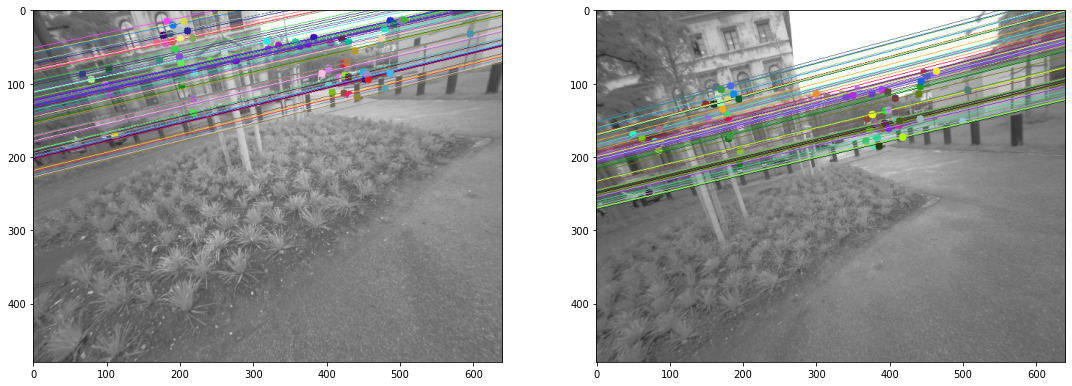

In [71]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
# plt.subplot(121),plt.imshow(img5)
# plt.subplot(122),plt.imshow(img3)
# plt.show()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img5)
ax[1].imshow(img3)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

In [43]:
E, mask = cv2.findEssentialMat(pts1, pts2, camera_matrix, cv2.RANSAC, 0.5)
rot1, rot2, trans = cv2.decomposeEssentialMat(E)
solution = find_projection_matrix(
    camera_matrix, pts1.reshape(-1,1,2), pts2.reshape(-1,1,2), rot1, rot2, trans, choices=2
)

Exception: Couldnt find any solution to point triangulation

In [ ]:
pts_3d = cv2.triangulatePoints(
    solution['pro_mat_1st'], solution['pro_mat_2nd'], pts1.T, pts2.T
)